In [2]:
from util import *
import json
# Load the prompt
with open('./hidden_unit_activity/prompt_bank.json', 'r') as file:
    prompt_bank = json.load(file)

from huggingface_hub import login
# Log in with your API token
login(token="YOURTOKENHERE")
import transformers
import torch
import numpy as np
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
model_id = "meta-llama/Meta-Llama-3-8B"

/mnt/data3/swu/miniforge3/envs/env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import re
trainkey = 'prompt_with_cheesecake_train'
testkey = 'prompt_with_cheesecake_test'

input_text = prompt_bank[trainkey]
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokens = obtain_sentence_wise_token(tokenizer, input_text, device)

In [3]:
word = 'cheese'
variants = [word[0].lower(), word[0].upper()]
spaces = ['',' ']
for item in  itertools.product(variants, itertools.product(spaces, repeat=2)):
    print(item)
combinations = [f"{space_before}{first_letter}{word[1:]}{space_after}" for first_letter, (space_before, space_after) in itertools.product(variants, itertools.product(spaces, repeat=2))]
print(combinations)

('c', ('', ''))
('c', ('', ' '))
('c', (' ', ''))
('c', (' ', ' '))
('C', ('', ''))
('C', ('', ' '))
('C', (' ', ''))
('C', (' ', ' '))
['cheese', 'cheese ', ' cheese', ' cheese ', 'Cheese', 'Cheese ', ' Cheese', ' Cheese ']


In [4]:
prompt_bank[trainkey]

'Cheese is one of the most versatile ingredients in the culinary world, and cheese can be used in everything from savory dishes to desserts. Cheese lovers often enjoy pairing cheese with crackers, wine, or fruit, but cheese also shines in baking. Cake, on the other hand, is the quintessential dessert, with cake being a staple at celebrations. Cake comes in many forms, such as chocolate cake, vanilla cake, or even carrot cake. However, when you bring cheese and cake together to create cheesecake, a magical transformation happens. Cheesecake is a dessert like no other, with cheesecake offering the creaminess of cheese and the sweetness of cake in perfect harmony. Cheesecake can be topped with fruits like strawberries or blueberries, or cheesecake can be flavored with chocolate or caramel. Some people prefer classic cheesecake, while others enjoy a more decadent cheesecake loaded with toppings. Regardless of the variation, cheesecake remains one of the most beloved desserts worldwide. The

In [5]:
prompt_bank[testkey]

'Cheese is a culinary treasure that has delighted taste buds for centuries. Whether it’s creamy, tangy, or sharp, cheese offers endless possibilities. Cheese finds its way into countless dishes, from savory casseroles to gooey pizzas, and its versatility knows no bounds. Cake, too, is a universal favorite, with cake symbolizing joy, celebration, and indulgence. Cake comes in every flavor imaginable—chocolate cake, vanilla cake, red velvet cake—and each cake brings its own special charm. But when cheese and cake are combined to form cheesecake, something truly extraordinary happens. Cheesecake is a dessert that transcends expectations, merging the velvety richness of cheese with the sweet, airy allure of cake. Cheesecake can be baked or chilled, simple or elaborate, yet every cheesecake captures the perfect balance of flavors. Classic cheesecake recipes highlight the creamy taste of cheese, while fruit-topped cheesecake adds a burst of freshness. Some people swear by chocolate cheesecak

In [ ]:
for step in [-2,-1,0,1,2]:# step positive: prediction, step negative, postdiction 
    decode_chunks('cheese', trainkey, testkey, prompt_bank, device, step = step, n_training = 5, partword = True)  

In [ ]:
for step in [-2,-1,0,1,2]:
    decode_chunks('cake', trainkey, testkey, prompt_bank, device, step = step, n_training = 5, partword = True)

In [ ]:
for step in [-2,-1,0,1,2]:
    decode_chunks('cheesecake', trainkey, testkey, prompt_bank, device, step = step, n_training = 5,partword = True)

In [ ]:
import pickle
with open("./neural_chunk_dictionary/neural_chunk_dictionary.pkl", "rb") as file:
    neural_chunk_dictionary = pickle.load(file)
nlayer = 32
word = 'cheese'
step = 2
l = 3
d = 4096
#neural_chunk_dictionary[word][step]['layer'][l] 
constant_values = neural_chunk_dictionary[word][step]['layer'][l]['constant_values']
constant_positions = neural_chunk_dictionary[word][step]['layer'][l]['constant_positions'][:,1] # perturb so the network thinks that it is a cake, instead of cheese cake 
tol = neural_chunk_dictionary[word][step]['layer'][l]['tolerance']

embedding = np.zeros([nlayer,d])
embedding[1,constant_positions] = constant_values
# if modified_input.shape[1]>1:
#     modified_input[:, constant_positions] = constant_values #shape  torch.Size([1, 8, 4096])



In [29]:
def z_score_along_embedding(matrix):
    mean = np.mean(matrix, axis=-1, keepdims=True)  
    std = np.std(matrix, axis=-1, keepdims=True)   
    z_scored_matrix = (matrix - mean) / std
    return z_scored_matrix

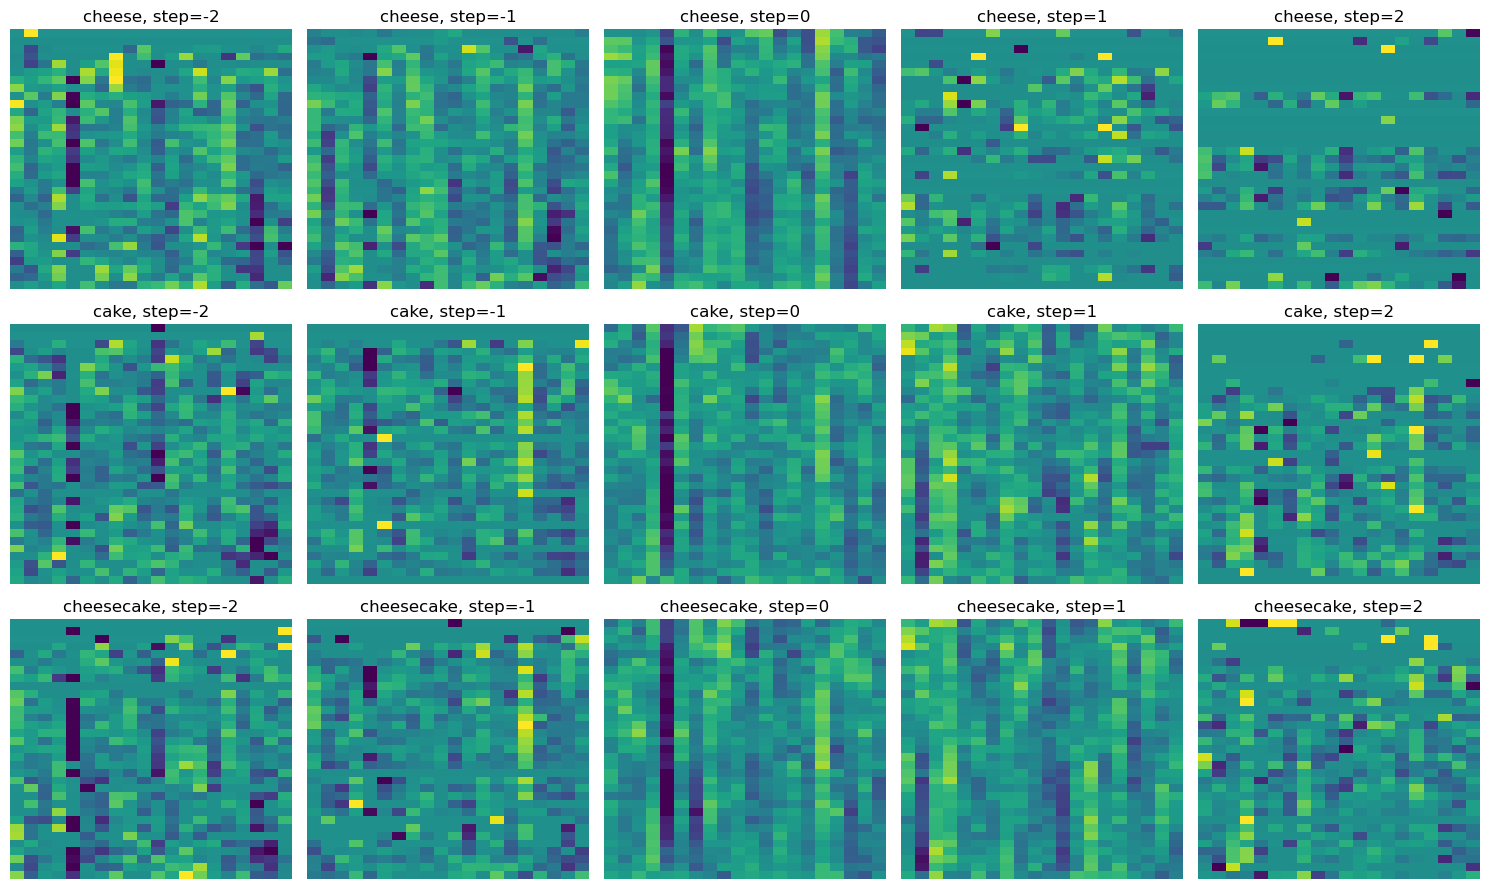

In [52]:
import pickle
nrows = 3
words = ['cheese','cake', 'cheesecake']
steps = [-2,-1,0,1,2]
ncols = len(steps)
nlayer = 33
n_neuron_shown = 30
fig, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows))

for k in range(0, len(words)):
    word = words[k]
    embedding = np.zeros([len(steps),nlayer,d])
    with open("./neural_chunk_dictionary/neural_chunk_dictionary.pkl", "rb") as file:
        neural_chunk_dictionary = pickle.load(file)
        
    for i in range(0, len(steps)): 
        step = steps[i]
        for l in range(0,nlayer):
            constant_values = neural_chunk_dictionary[word][step]['layer'][l]['constant_values'] 
            constant_positions = neural_chunk_dictionary[word][step]['layer'][l]['constant_positions'][:,1]
            dev_threshold = neural_chunk_dictionary[word][step]['layer'][l]['tolerance']
            embedding[i,l,constant_positions] = constant_values
    
    normalized_ebd = z_score_along_embedding(embedding)    
    # fig, axes = plt.subplots(1, len(steps), figsize=(15, 3))  # 1 row, 2 columns
    VMIN = -3
    VMAX = 3
    n_neuron_shown = 20 
    for i in range(0, len(steps)): 
        axes[k,i].imshow(normalized_ebd[i,:,:n_neuron_shown], cmap='viridis', aspect='auto', vmin = VMIN, vmax = VMAX)
        axes[k,i].set_title(f"{word}, step={steps[i]}")
        axes[k,i].axis('off')  # Turn off axis if not needed

fig.savefig(f"./plots/cheesecake.png", bbox_inches='tight')
# Adjust layout
plt.tight_layout()
plt.show()

